# Train ResDepth on the crunchy-snow dataset

In [1]:
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import pickle

import crunchy_snow.models
import crunchy_snow.dataset

## Prepare dataloader

In [2]:
# get paths to data
train_data_dir = '/mnt/Backups/gbrench/repos/crunchy-snow/data/subsets_v2/train'
train_path_list = glob(f'{train_data_dir}/ASO_50M_SD*.nc') #[10000:10002]

val_data_dir = '/mnt/Backups/gbrench/repos/crunchy-snow/data/subsets_v2/val'
val_path_list = glob(f'{val_data_dir}/ASO_50M_SD*.nc') #[0:2]

In [3]:
# define data to be returned by dataloader
selected_channels = [
    # ASO products
    'aso_sd', # ASO lidar snow depth (target dataset)
    'aso_gap_map', # gaps in ASO data
    
    # Sentinel-1 products
    'snowon_vv', # snow on Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vh', # snow on Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vv', # snow off Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vh', # snow off Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vv_mean', # snow on Sentinel-1 VV polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowon_vh_mean', # snow on Sentinel-1 VH polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowoff_vv_mean', # snow off Sentinel-1 VV polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowoff_vh_mean', # snow off Sentinel-1 VH polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowon_cr', # cross ratio, snowon_vh - snowon_vv
    'snowoff_cr', # cross ratio, snowoff_vh - snowoff_vv
    'delta_cr', # change in cross ratio, snowon_cr - snowoff_cr
    'rtc_gap_map', # gaps in Sentinel-1 data
    'rtc_mean_gap_map', # gaps in Sentinel-1 mean data
    
    # Sentinel-2 products 
    'aerosol_optical_thickness', # snow on Sentinel-2 aerosol optical thickness band 
    'coastal_aerosol', # snow on Sentinel-2 coastal aerosol band
    'blue', # snow on Sentinel-2 blue band
    'green', # snow on Sentinel-2 green band
    'red', # snow on Sentinel-2 red band
    'red_edge1', # snow on Sentinel-2 red edge 1 band
    'red_edge2', # snow on Sentinel-2 red edge 2 band
    'red_edge3', # snow on Sentinel-2 red edge 3 band
    'nir', # snow on Sentinel-2 near infrared band
    'water_vapor', # snow on Sentinel-2 water vapor
    'swir1', # snow on Sentinel-2 shortwave infrared band 1
    'swir2', # snow on Sentinel-2 shortwave infrared band 2
    'scene_class_map', # snow on Sentinel-2 scene classification product
    'water_vapor_product', # snow on Sentinel-2 water vapor product
    'ndvi', # Normalized Difference Vegetation Index from Sentinel-2
    'ndsi', # Normalized Difference Snow Index from Sentinel-2
    'ndwi', # Normalized Difference Water Index from Sentinel-2
    's2_gap_map', # gaps in Sentinel-2 data

    # PROBA-V global land cover dataset (Buchhorn et al., 2020)
    'fcf', # fractional forest cover
    
    # COP30 digital elevation model      
    'elevation',

    # latitude and longitude
    'latitude',
    'longitude',

    # day of water year
    'dowy'
                    ]

# prepare training and validation dataloaders
train_data = crunchy_snow.dataset.Dataset(train_path_list, selected_channels, norm=True)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_data = crunchy_snow.dataset.Dataset(val_path_list, selected_channels, norm=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=1, shuffle=True)

In [4]:
# define input channels for model
input_channels = [
    'snowon_vv',
    'snowon_vh',
    'snowoff_vv',
    'snowoff_vh',
    'blue',
    'green',
    'red',
    'fcf',
    'elevation',
    'ndvi',
    'ndsi',
    'ndwi',
    'snowon_cr',
    'snowoff_cr']

## Train model

In [6]:
# import model
# model = crunchy_snow.models.SimpleCNN(n_input_channels=len(input_channels))
# model = crunchy_snow.models.UNet(n_input_channels=len(input_channels))
# model = crunchy_snow.models.ResUNet(n_input_channels=len(input_channels))
# model = crunchy_snow.models.ResDepth(n_input_channels=len(input_channels))
# model = crunchy_snow.models.VisionTransformer(n_input_channels=len(input_channels))

model = crunchy_snow.models.ResDepth(n_input_channels=len(input_channels))
model.to('cuda');  # Run on GPU

# name your model
model_name = 'quinn_ResDepth_v3'

In [ ]:
# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=0.0003)
loss_fn = nn.MSELoss()
epochs = 50

train_loss = []
val_loss = []

# training and validation loop
for epoch in range(epochs):
    print(f'\nStarting epoch {epoch+1}')
    epoch_loss = []
    val_temp_loss = []

    # Loop through training data with tqdm progress bar
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch", ncols=130)
    for data_tuple in pbar:
        model.train()
        optimizer.zero_grad()

        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
        # prepare inputs by concatenating along channel dimension
        inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')

        # generate prediction
        pred_sd = model(inputs)

        # Limit prediction to areas with valid data
        pred_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
        aso_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda')== 0, data_dict['aso_sd'].to('cuda'), torch.zeros_like(pred_sd).to('cuda'))

        # Calculate loss
        loss = loss_fn(pred_sd, aso_sd.to('cuda'))
        epoch_loss.append(loss.item())

        # Update tqdm progress bar with batch loss
        pbar.set_postfix({'batch loss': loss.item(), 'mean epoch loss': np.mean(epoch_loss)})


        loss.backward()  # Propagate the gradients in backward pass
        optimizer.step()

    train_loss.append(np.mean(epoch_loss))
    print(f'Training loss: {np.mean(epoch_loss)}')

    # Run model on validation data with tqdm progress bar
    for data_tuple in tqdm(val_loader, desc="Validation", unit="batch"):
        with torch.no_grad():
            model.eval()
            
            # read data into dictionary
            data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
            # prepare inputs by concatenating along channel dimension
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
    
            # generate prediction
            pred_sd = model(inputs)
    
            # Limit prediction to areas with valid data
            pred_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
            aso_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, data_dict['aso_sd'].to('cuda'), torch.zeros_like(pred_sd).to('cuda'))
    
            # Calculate loss
            loss = loss_fn(pred_sd, aso_sd.to('cuda'))
            val_temp_loss.append(loss.item())

    val_loss.append(np.mean(val_temp_loss))
    print(f'Validation loss: {np.mean(val_temp_loss)}')
    
    # save model
    torch.save(model.state_dict(), f'../../../weights/{model_name}')

    # save loss 
    with open(f'../../../loss/{model_name}_val_loss.pkl', 'wb') as f:
        pickle.dump(val_loss, f)
        
    with open(f'../../../loss/{model_name}_train_loss.pkl', 'wb') as f:
        pickle.dump(train_loss, f)


## Examine results

In [10]:
#load previous model
model = crunchy_snow.models.ResDepth(n_input_channels=len(input_channels))
model.load_state_dict(torch.load(f'../../../weights/{model_name}'))
model.to('cuda');

/tmp/ipykernel_4569/4015514556.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../../../weights/{model_name}'));


In [ ]:
# plot loss over all epochs
f, ax = plt.subplots(figsize=(10,5))
ax.plot(train_loss, label='training')
ax.plot(val_loss, label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('MSE loss')
ax.set_title('Loss')
ax.legend()

# save figure
plt.savefig(f'../../../figs/{model_name}_loss.png', dpi=300)

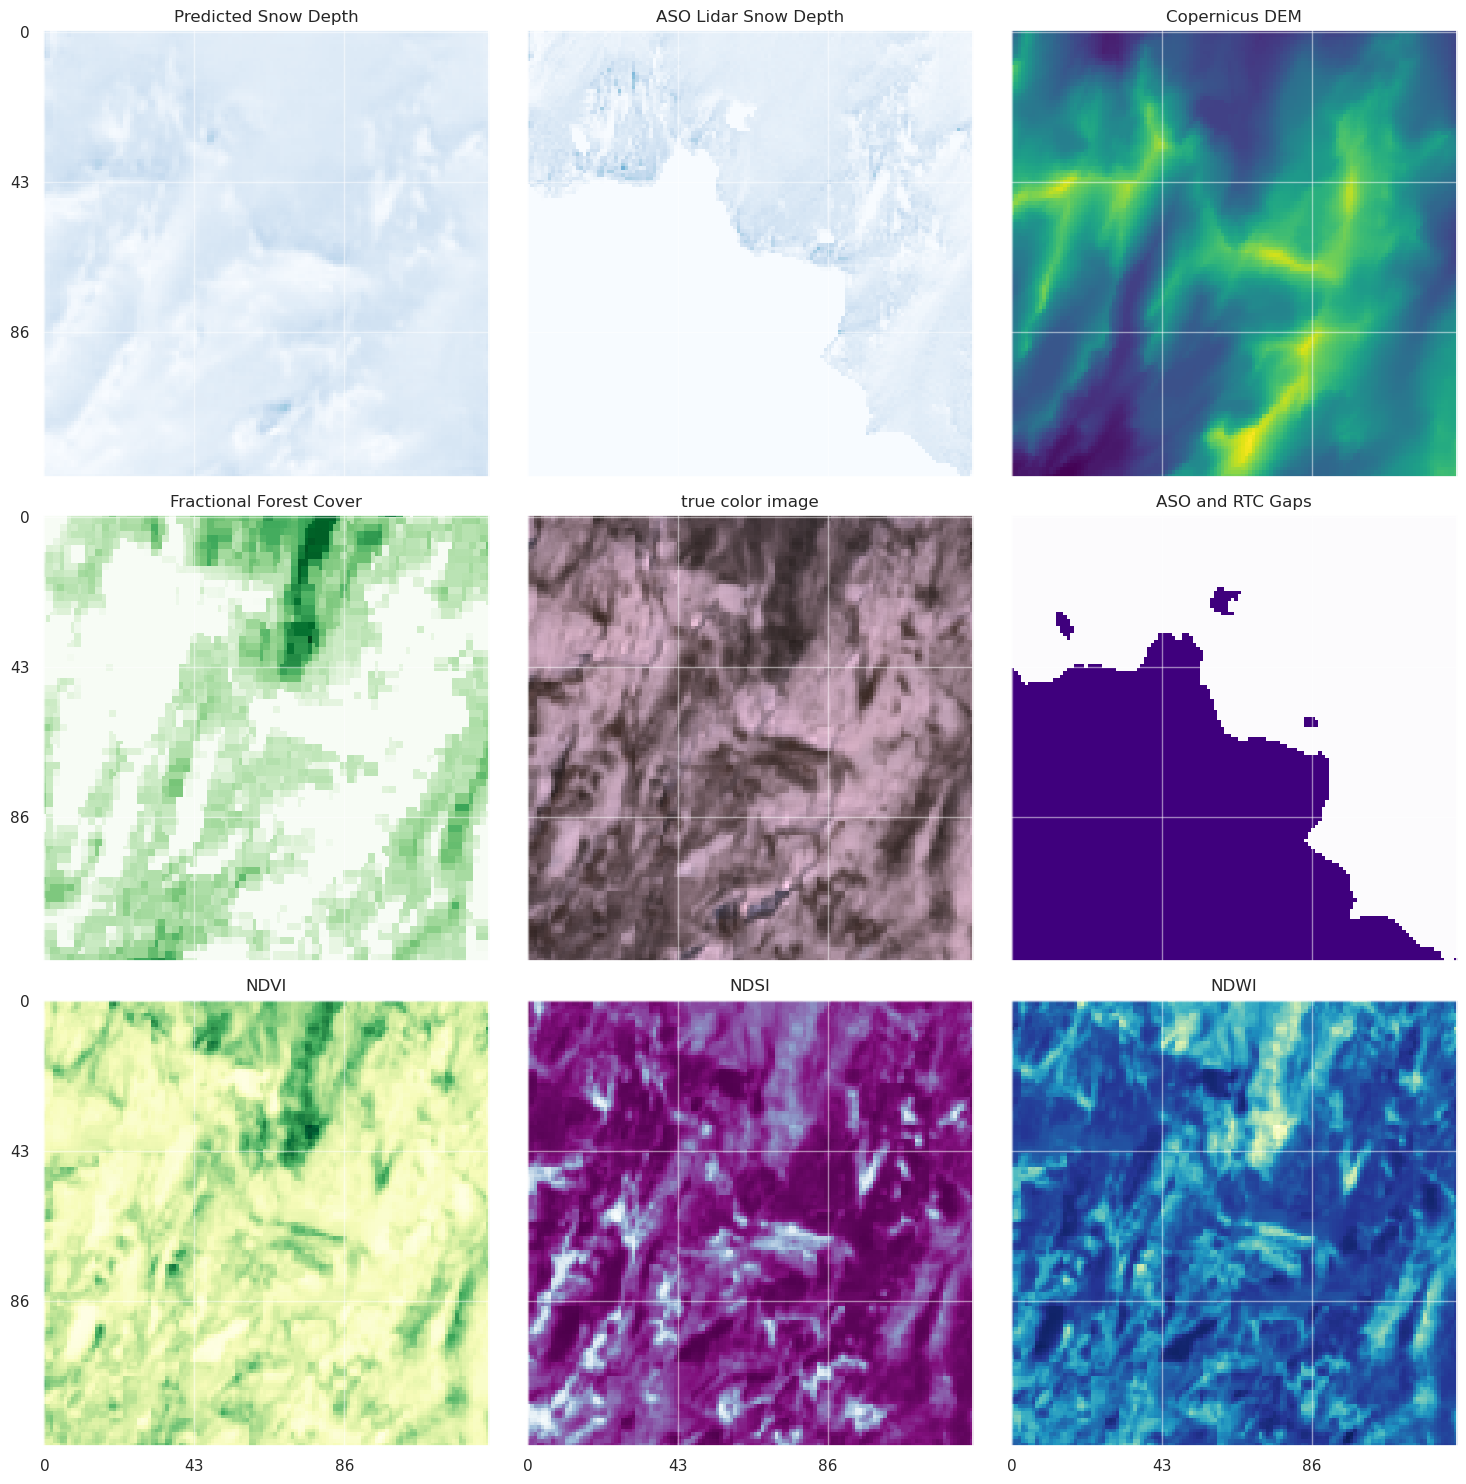

In [27]:
# visualize model predictions
sns.set_theme()
num_samples = 1

for i, data_tuple in enumerate(val_loader):
    if i < num_samples:
        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}

        with torch.no_grad():
            # Concatenate input feature channels, make prediction
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
            pred_sd = model(inputs)  # Generate predictions using the model
            pred_sd = pred_sd.to('cpu')
        
        f, ax = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
        ax[0, 0].imshow(pred_sd.squeeze(), cmap='Blues', vmin=0, vmax=0.4, interpolation=None)
        ax[0, 0].set_title('Predicted Snow Depth')
        ax[0, 1].imshow(data_dict['aso_sd'].squeeze(), cmap='Blues', vmin=0, vmax=0.4, interpolation=None)
        ax[0, 1].set_title('ASO Lidar Snow Depth')
        ax[0, 2].imshow(data_dict['elevation'].squeeze(), cmap='viridis', interpolation='none')
        ax[0, 2].set_title('Copernicus DEM')
        ax[1, 0].imshow(data_dict['fcf'].squeeze(), cmap='Greens', interpolation='none')
        ax[1, 0].set_title('Fractional Forest Cover')
        norm_max = np.max([data_dict['green'].max(), data_dict['red'].max(), data_dict['blue'].max()]) # there are better ways to do this
        ax[1, 1].imshow(torch.cat((data_dict['red'].squeeze()[:, :, None]/norm_max, data_dict['green'].squeeze()[:, :, None]/norm_max, data_dict['blue'].squeeze()[:, :, None]/norm_max), 2).squeeze(), interpolation='none')
        ax[1, 1].set_title('true color image')
        ax[1, 2].imshow(data_dict['aso_gap_map'].squeeze() + data_dict['rtc_gap_map'].squeeze() + data_dict['s2_gap_map'].squeeze(), cmap='Purples', interpolation='none')
        ax[1, 2].set_title('ASO and RTC Gaps')
        ax[2, 0].imshow(data_dict['ndvi'].squeeze(), cmap='YlGn', interpolation='none')
        ax[2, 0].set_title('NDVI')
        ax[2, 1].imshow(data_dict['ndsi'].squeeze(), cmap='BuPu', interpolation='none')
        ax[2, 1].set_title('NDSI')
        ax[2, 2].imshow(data_dict['ndwi'].squeeze(), cmap='YlGnBu', interpolation='none')
        ax[2, 2].set_title('NDWI')
        
        # modify plot style
        for a in ax.flat:
            a.set_aspect('equal')
            a.set_xticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[1], 43))
            a.set_yticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[0], 43))
            a.grid(True, linewidth=1, alpha=0.5)
        
        f.tight_layout()
    else:
        break


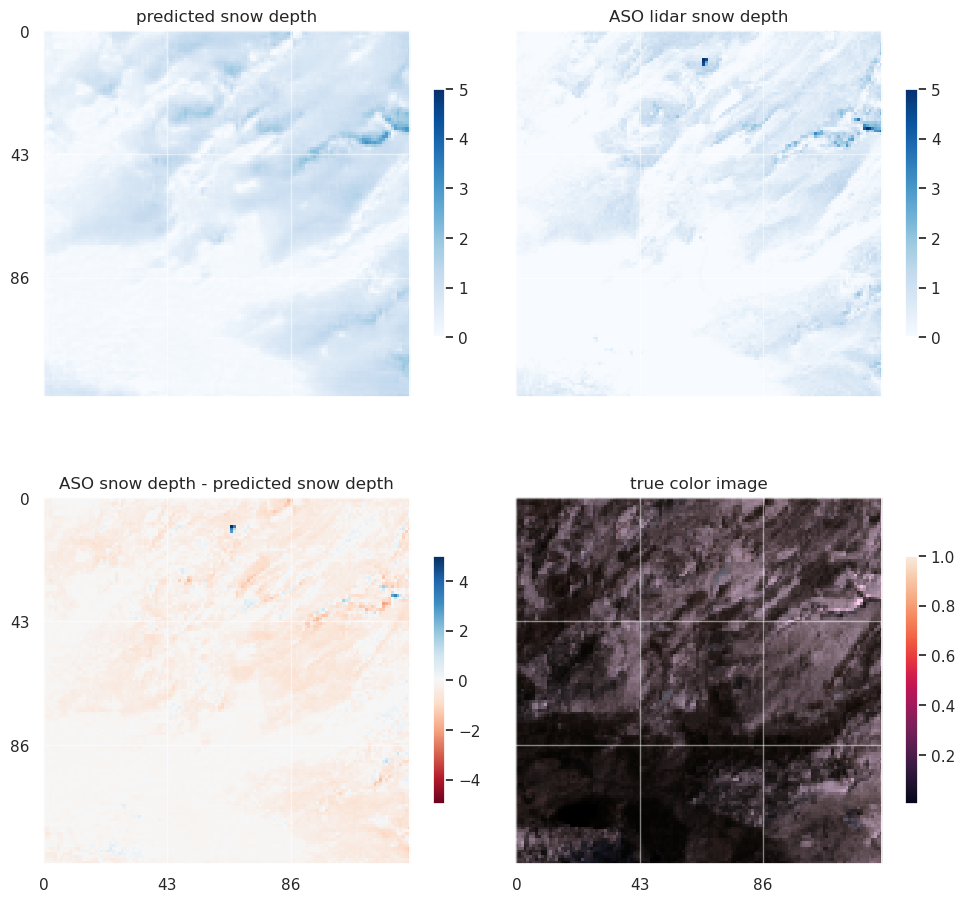

In [129]:
# visualize prediction error
sns.set_theme()
num_samples = 1
norm_dict = crunchy_snow.dataset.norm_dict

for i, data_tuple in enumerate(val_loader):
    if i < num_samples:
        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}

        with torch.no_grad():
            # Concatenate input feature channels, make prediction
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
            pred_sd = model(inputs)  # Generate predictions using the model
            pred_sd = pred_sd.to('cpu')

            # mask nodata areas
            pred_sd = torch.where(data_dict['aso_gap_map'] + data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, pred_sd, torch.zeros_like(pred_sd))
            aso_sd = torch.where(data_dict['aso_gap_map'] + data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, data_dict['aso_sd'], torch.zeros_like(pred_sd))

            # undo normalization
            pred_sd = crunchy_snow.dataset.undo_norm(pred_sd, crunchy_snow.dataset.norm_dict['aso_sd']).squeeze()
            aso_sd = crunchy_snow.dataset.undo_norm(aso_sd, crunchy_snow.dataset.norm_dict['aso_sd']).squeeze()
            
            # mask values below 0
            pred_sd = torch.where(pred_sd >= 0, pred_sd, torch.zeros_like(pred_sd))
            
            f, ax = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
            im0 = ax[0, 0].imshow(pred_sd, cmap='Blues', vmin=0, vmax=5, interpolation='none') 
            ax[0, 0].set_title('predicted snow depth')
            f.colorbar(im0, shrink=0.5)
            im1 = ax[0, 1].imshow(aso_sd, cmap='Blues', vmin=0, vmax=5, interpolation='none')
            ax[0, 1].set_title('ASO lidar snow depth')
            f.colorbar(im1, shrink=0.5)

            im2 = ax[1, 0].imshow(aso_sd-pred_sd, cmap='RdBu', vmin=-5, vmax=5, interpolation='none') 
            ax[1, 0].set_title('ASO snow depth - predicted snow depth')
            f.colorbar(im2, shrink=0.5)
            norm_max = np.max([data_dict['green'].max(), data_dict['red'].max(), data_dict['blue'].max()]) # there are better ways to do this
            im3 = ax[1, 1].imshow(torch.cat((data_dict['red'].squeeze()[:, :, None]/norm_max, data_dict['green'].squeeze()[:, :, None]/norm_max, data_dict['blue'].squeeze()[:, :, None]/norm_max), 2).squeeze(), interpolation='none')
            ax[1, 1].set_title('true color image')
            f.colorbar(im3, shrink=0.5)

            # Set modify plot style
            for a in ax.flat:
                a.set_aspect('equal')
                a.set_xticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[1], 43))
                a.set_yticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[0], 43))
                a.grid(True, linewidth=1, alpha=0.5)

            plt.tight_layout()
    else: 
        break